In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
# pip install tensorflow

In [4]:
import tensorflow as tf


C:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import numpy as np
import pandas as pd

In [6]:
from tensorflow import keras 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
                                                   shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE
                                                   )

Found 2152 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

In [10]:
68*32


2176

In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[159. 145. 144.]
  [153. 139. 138.]
  [147. 133. 132.]
  ...
  [150. 140. 139.]
  [156. 146. 145.]
  [170. 160. 159.]]

 [[151. 137. 136.]
  [146. 132. 131.]
  [137. 123. 122.]
  ...
  [155. 145. 144.]
  [158. 148. 147.]
  [168. 158. 157.]]

 [[150. 136. 135.]
  [152. 138. 137.]
  [145. 131. 130.]
  ...
  [161. 151. 150.]
  [161. 151. 150.]
  [168. 158. 157.]]

 ...

 [[112. 101. 107.]
  [110.  99. 105.]
  [110.  99. 105.]
  ...
  [155. 145. 153.]
  [137. 127. 135.]
  [147. 137. 145.]]

 [[108.  97. 103.]
  [108.  97. 103.]
  [109.  98. 104.]
  ...
  [158. 148. 156.]
  [138. 128. 136.]
  [143. 133. 141.]]

 [[104.  93.  99.]
  [105.  94. 100.]
  [108.  97. 103.]
  ...
  [148. 138. 146.]
  [151. 141. 149.]
  [145. 135. 143.]]], shape=(256, 256, 3), dtype=float32)


In [12]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[122. 109. 118.]
  [118. 105. 114.]
  [112.  99. 108.]
  ...
  [168. 161. 169.]
  [167. 160. 168.]
  [163. 156. 164.]]

 [[110.  97. 106.]
  [111.  98. 107.]
  [114. 101. 110.]
  ...
  [167. 160. 168.]
  [166. 159. 167.]
  [164. 157. 165.]]

 [[122. 109. 118.]
  [119. 106. 115.]
  [117. 104. 113.]
  ...
  [164. 157. 165.]
  [164. 157. 165.]
  [164. 157. 165.]]

 ...

 [[129. 118. 132.]
  [110.  99. 113.]
  [132. 121. 135.]
  ...
  [143. 137. 151.]
  [150. 144. 158.]
  [158. 152. 166.]]

 [[125. 114. 128.]
  [125. 114. 128.]
  [130. 119. 133.]
  ...
  [151. 145. 159.]
  [152. 146. 160.]
  [153. 147. 161.]]

 [[107.  96. 110.]
  [125. 114. 128.]
  [120. 109. 123.]
  ...
  [164. 158. 172.]
  [161. 155. 169.]
  [155. 149. 163.]]]


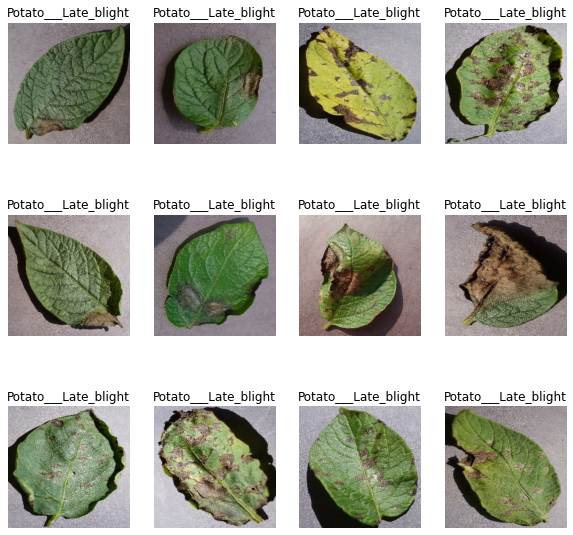

In [13]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))#convertfrom float
        plt.axis("off")#shuffle is on
        plt.title(class_names[label_batch[0]])

In [14]:
#80% ==>training
#20% ==>10% validation,10%test

In [15]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds=dataset.take(54)
len(train_ds)

54

In [17]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#datestoptamized

In [25]:
#preprocessing


In [26]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/225)
    
])

In [27]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


54/54 [==============================] - 86s 1s/step - loss: 0.9109 - accuracy: 0.5503 - val_loss: 0.8271 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 68s 1s/step - loss: 0.7147 - accuracy: 0.7078 - val_loss: 0.5174 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 59s 1s/step - loss: 0.4321 - accuracy: 0.8206 - val_loss: 0.4347 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 60s 1s/step - loss: 0.3250 - accuracy: 0.8738 - val_loss: 0.2420 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 0.2203 - accuracy: 0.9155 - val_loss: 0.2243 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 59s 1s/step - loss: 0.2247 - accuracy: 0.9109 - val_loss: 0.1790 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 59s 1s/step - loss: 0.2070 - accuracy: 0.9190 - val_loss: 0.1367 - val_accuracy: 0.9531
Epoch 8/50
54/54 [

In [32]:
score=model.evaluate(test_ds)


8/8 [==============================] - 7s 328ms/step - loss: 0.1286 - accuracy: 0.9570


In [33]:
score


[0.12861505150794983, 0.95703125]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


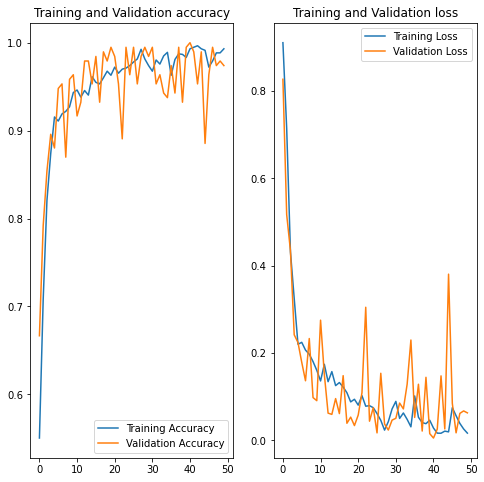

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

first image to predict
actual label Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


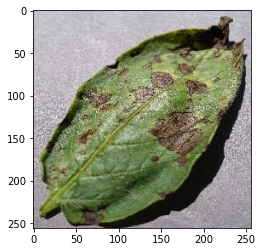

In [39]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [40]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch
    
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(batch_prediction[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 89ms/step


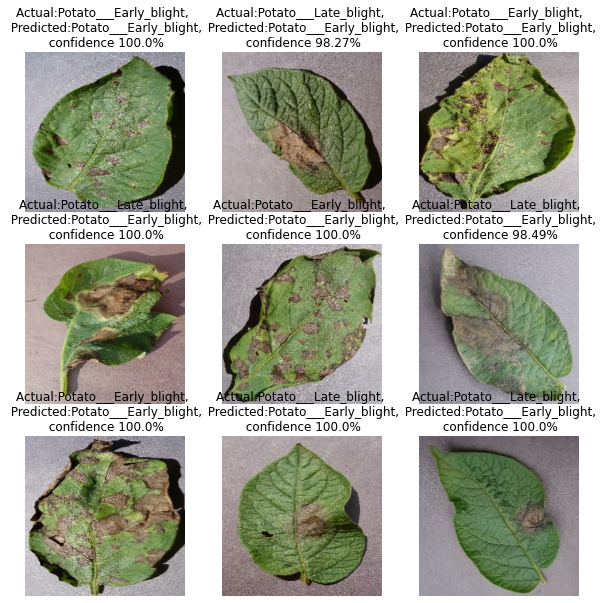

In [41]:
plt.figure(figsize=(10,10))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        
        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class}, \n Predicted:{predicted_class},\n confidence { confidence}%")
        
        plt.axis("off")
        #plt.axis("off")

In [42]:
import os 
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'